## LSTM-ED for Anomaly Detection in Time Series Data

In [1]:

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *
from models_funtions import *

# Set style for matplotlib
plt.style.use("Solarize_Light2")

import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#### Variours parameters

In [4]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

file_name_normal = "_20220811_rbtc_"
file_name_collisions = "_collision_20220811_rbtc_"

recording_normal = [0, 2, 3, 4]
recording_collisions = [1, 5]

freq_str = freq.replace(".", "_")
features_folder_normal = f"./features/normal{freq_str}/"
features_folder_collisions = f"./features/collisions{freq_str}/"

### Data

In [5]:
df_features_normal, df_normal_raw, _ = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, f"{features_folder_normal}")
df_features_collisions, df_collisions_raw, df_collisions_raw_action = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, f"{features_folder_collisions}1_5/")
df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, f"{features_folder_collisions}1/")
df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, f"{features_folder_collisions}5/")

Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Features saved to ./features/normal0_1/features_statistical_10.0.csv.
--- 91.89773917198181 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Features saved to ./features/collisions0_1/1_5/features_statistical_10.0.csv.
--- 29.615127563476562 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Features saved to ./features/collisions0_1/1/features_statistical_10.0.csv.
--- 17.279357433319092 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Features saved to ./features/collisions0_1/5/features_statistical_10.0.csv.
--- 16.493605613708496 seconds ---


In [6]:
X_train, y_train, X_test, y_test, df_test = get_train_test_data(df_features_normal, df_features_collisions, full_normal=True)
X_train_1, y_train_1, X_test_1, y_test_1, df_test_1 = get_train_test_data(df_features_normal, df_features_collisions_1, full_normal=True)
X_train_5, y_train_5, X_test_5, y_test_5, df_test_5 = get_train_test_data(df_features_normal, df_features_collisions_5, full_normal=True)

### Collisions

In [7]:
collisions_rec1, collisions_init1 = get_collisions('1', ROOTDIR_DATASET_ANOMALY)
collisions_rec5, collisions_init5 = get_collisions('5', ROOTDIR_DATASET_ANOMALY)

# Merge the collisions of the two recordings in one dataframe
collisions_rec = pd.concat([collisions_rec1, collisions_rec5])
collisions_init = pd.concat([collisions_init1, collisions_init5])

In [8]:
collisions_zones, y_collisions = get_collisions_zones_and_labels(collisions_rec, collisions_init, df_features_collisions)
collisions_zones_1, y_collisions_1 = get_collisions_zones_and_labels(collisions_rec1, collisions_init1, df_features_collisions_1)
collisions_zones_5, y_collisions_5 = get_collisions_zones_and_labels(collisions_rec5, collisions_init5, df_features_collisions_5)

## Autoencoder for Anomaly Detection in Time Series Data

In [9]:
from algorithms.autoencoder import AutoEncoder

classifier = AutoEncoder(
    name='AutoEncoder',
    num_epochs=100,
    batch_size=32,
    lr=1e-3,
    hidden_size=32,
    sequence_length=5,
    train_gaussian_percentage=0.25,
    seed=42,
    gpu=None,
    details=True
)

# Train the AutoEncoder on normal data
classifier.fit(X_train)

print("AutoEncoder training completed.")

100%|██████████| 100/100 [00:10<00:00,  9.34it/s]

AutoEncoder training completed.


### Predictions

Anomaly prediction completed.
Number of anomalies detected: 11 with threshold 2502.92066358664, std
Number of anomalies detected: 105 with threshold 381.401240899639, mad
Number of anomalies detected: 16 with threshold 2041.1501885585585, percentile
Number of anomalies detected: 16 with threshold 2050.751298949901, IQR
Number of anomalies detected: 306 with threshold 0.0, zero

choosen threshold type: mad, with value: 381.4012
F1 Score: 0.8571
Accuracy: 0.9020
Precision: 0.8571
Recall: 0.8571
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       201
           1       0.86      0.86      0.86       105

    accuracy                           0.90       306
   macro avg       0.89      0.89      0.89       306
weighted avg       0.90      0.90      0.90       306

ROC AUC Score: 0.9756


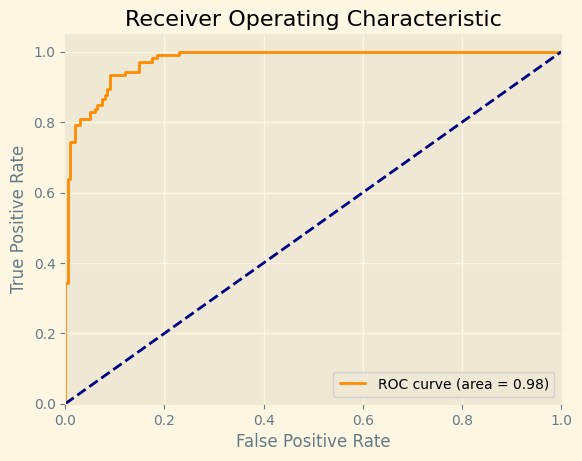

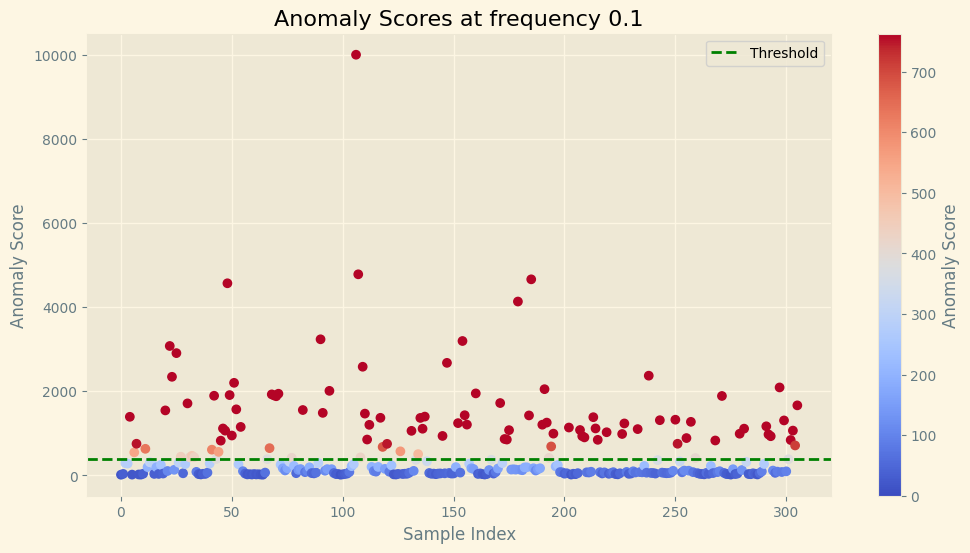

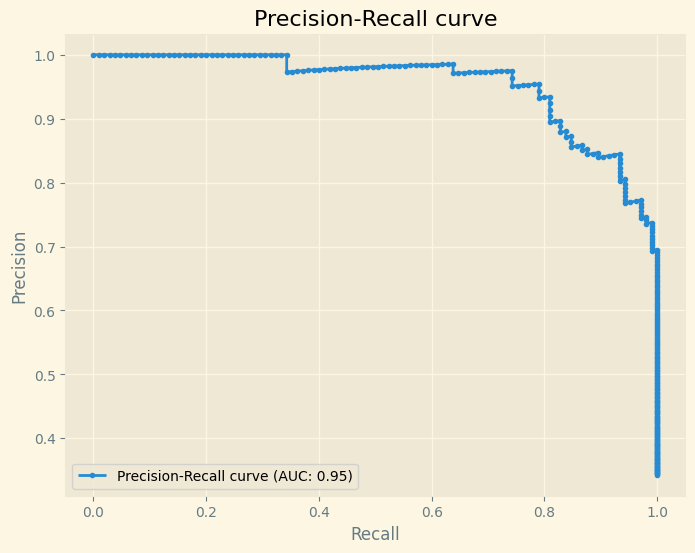

Anomalies detected: 105
Best threshold: 294.0906 | F1 Score: 0.8869 | Precision: 0.8448 | Recall: 0.9333

	-------------------------------------------------------------------------------------

Anomaly prediction completed.
Number of anomalies detected: 6 with threshold 2385.348516051506, std
Number of anomalies detected: 52 with threshold 158.5949724772964, mad
Number of anomalies detected: 9 with threshold 1878.520614041195, percentile
Number of anomalies detected: 17 with threshold 498.65784751872883, IQR
Number of anomalies detected: 164 with threshold 0.0, zero

choosen threshold type: mad, with value: 158.5950
F1 Score: 0.7816
Accuracy: 0.8841
Precision: 0.6538
Recall: 0.9714
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       129
           1       0.65      0.97      0.78        35

    accuracy                           0.88       164
   macro avg       0.82      0.92      0.85       164
weighted avg       0.92      0.88    

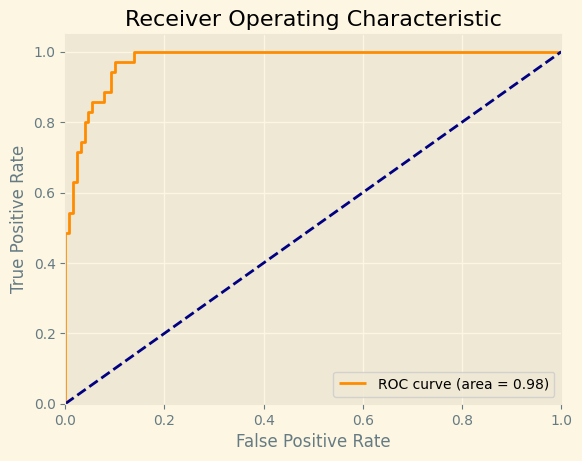

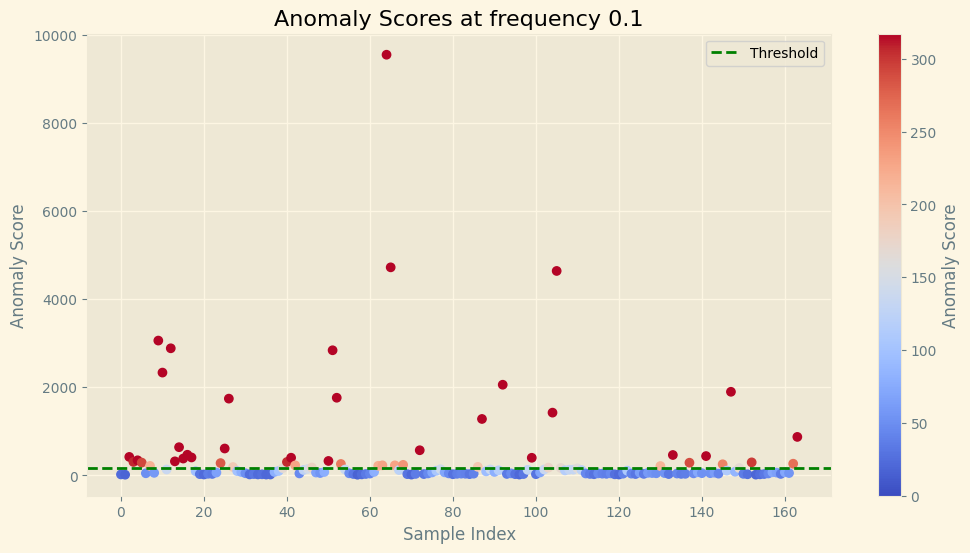

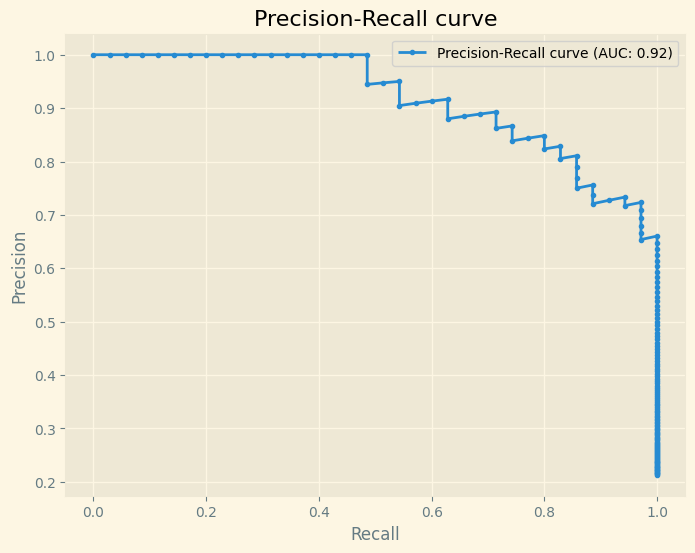

Anomalies detected: 52
Best threshold: 254.0145 | F1 Score: 0.8333 | Precision: 0.8108 | Recall: 0.8571

	-------------------------------------------------------------------------------------

Anomaly prediction completed.
Number of anomalies detected: 5 with threshold 2395.2284440121225, std
Number of anomalies detected: 16 with threshold 1692.8350265923068, mad
Number of anomalies detected: 8 with threshold 2102.417434633238, percentile
Number of anomalies detected: 4 with threshold 2654.5823369965565, IQR
Number of anomalies detected: 141 with threshold 0.0, zero

choosen threshold type: mad, with value: 1692.8350
F1 Score: 0.3889
Accuracy: 0.6879
Precision: 0.8750
Recall: 0.2500
              precision    recall  f1-score   support

           0       0.66      0.98      0.79        85
           1       0.88      0.25      0.39        56

    accuracy                           0.69       141
   macro avg       0.77      0.61      0.59       141
weighted avg       0.75      0.69   

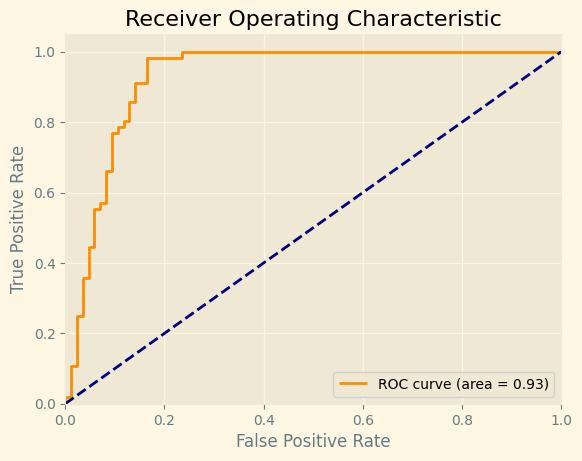

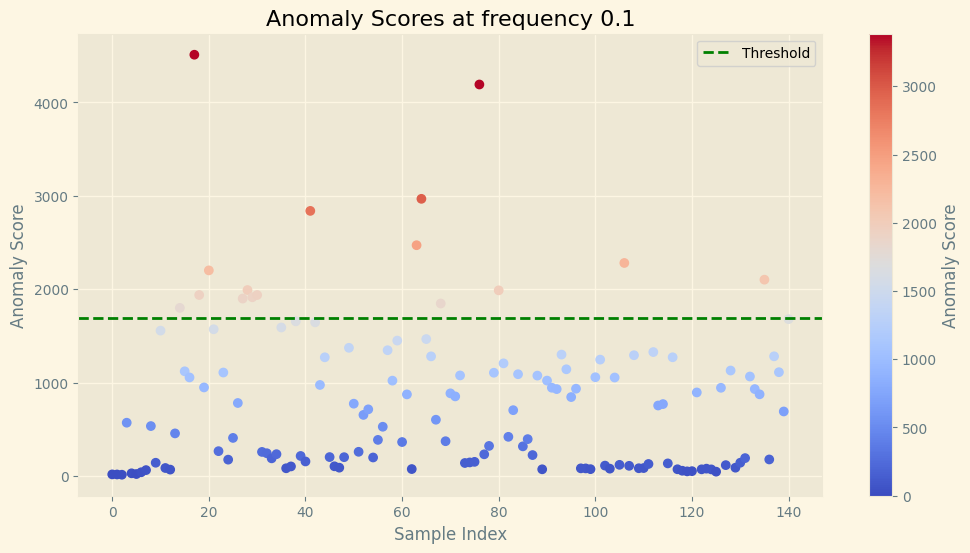

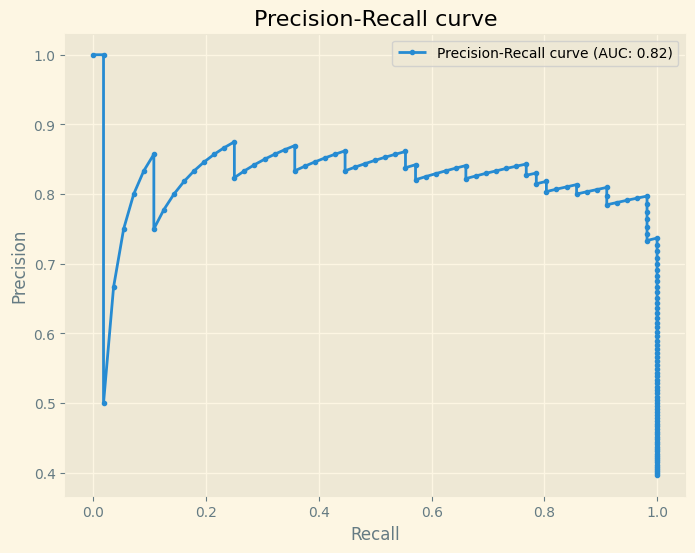

Anomalies detected: 16
Best threshold: 704.7551 | F1 Score: 0.8800 | Precision: 0.7971 | Recall: 0.9821

	-------------------------------------------------------------------------------------



In [10]:
df_test = get_statistics(X_test, y_collisions, classifier, df_test, freq, threshold_type="mad")
df_test_1 = get_statistics(X_test_1, y_collisions_1, classifier, df_test_1, freq, threshold_type="mad")
df_test_5 = get_statistics(X_test_5, y_collisions_5, classifier, df_test_5, freq, threshold_type="mad")

In [11]:
plot_anomalies_true_and_predicted(df_collisions_raw, df_collisions_raw_action, collisions_zones, df_test, title="Collisions zones vs predicted zones for both recordings")

In [12]:
plot_anomalies_true_and_predicted(df_collisions_raw_1, df_collisions_raw_action_1, collisions_zones_1, df_test_1, title="Collisions zones vs predicted zones for recording 1")

In [13]:
plot_anomalies_true_and_predicted(df_collisions_raw_5, df_collisions_raw_action_5, collisions_zones_5, df_test_5, title="Collisions zones vs predicted zones for recording 5")